<a href="https://colab.research.google.com/github/desiredominique/tensorflow_ml/blob/main/Teste_de_classifica%C3%A7%C3%A3o_para_seios_piriformes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importando os pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from scipy.ndimage import zoom

from keras.models import load_model

In [ ]:
# testes de aplicação de filtros com tensorflow

example_img = tf.io.read_file('/content/drive/MyDrive/Seios Piriformes/1/01_000001.jpg')

example_img = tf.io.decode_jpeg(example_img, channels = 1)

example_img = tf.image.convert_image_dtype(example_img, dtype=tf.float32)

example_img = tf.expand_dims(example_img,axis=0)

horizontal_sobel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

kernel = tf.constant(horizontal_sobel)
kernel = tf.reshape(kernel,shape=[*kernel.shape,1,1])
kernel = tf.cast(kernel, dtype=tf.float32)

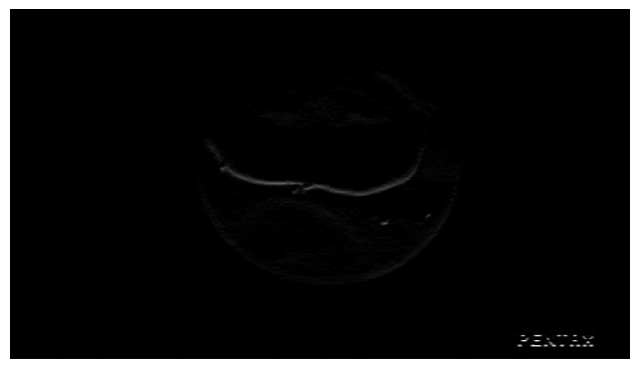

Forma da imagem: (1, 406, 720, 1)


In [ ]:
# primeira aplicação de filtro (filtro de cinza)
## não houve modificação considerável

img_filter = tf.nn.conv2d(input = example_img,filters=kernel,strides=1,padding="SAME")

img_detect = tf.nn.relu(img_filter)

plt.figure(figsize=(8, 8))
plt.imshow(tf.squeeze(img_detect),cmap="gray")
plt.axis("off")
plt.show();
print("Forma da imagem:",img_detect.shape)

(1, 203, 360, 1)


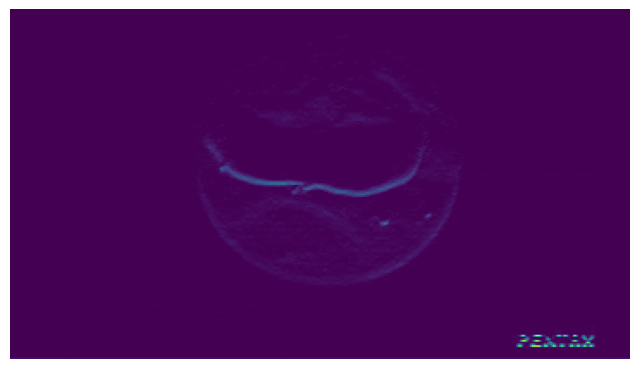

Forma da imagem: (1, 203, 360, 1)


In [ ]:
# segunda aplicação de filtro (filtro roxo)

img_condense = tf.nn.pool(
    input=img_detect,
    window_shape=(2, 2),
    pooling_type='MAX', #você pode trocar para MAX
    strides=(2, 2), #garante dimensão reduzida
    padding='SAME',
)

print(img_condense.shape)
plt.figure(figsize=(8, 8))
plt.imshow(tf.squeeze(img_condense))
plt.axis('off')
plt.show();
print("Forma da imagem:",img_condense.shape)

In [ ]:
# inserindo os dados de treinamento

ds_train = image_dataset_from_directory(
    '/content/drive/MyDrive/Seios Piriformes',
    labels='inferred',
    label_mode = "categorical",
    image_size=[128, 128],
    validation_split = 0.3, #30% de validação
    subset="training",
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    seed=42
)

Found 432 files belonging to 2 classes.
Using 303 files for training.


In [ ]:
# dados de validação

ds_valid = image_dataset_from_directory(
    '/content/drive/MyDrive/Seios Piriformes',
    labels='inferred',
    label_mode = "categorical",
    image_size=[128, 128],
    validation_split = 0.3, #30% de validação
    subset="validation",
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    seed=42
)

Found 432 files belonging to 2 classes.
Using 129 files for validation.


In [ ]:
# mostrando os nomes das classes

class_names = ds_train.class_names
class_names

['1', '5']

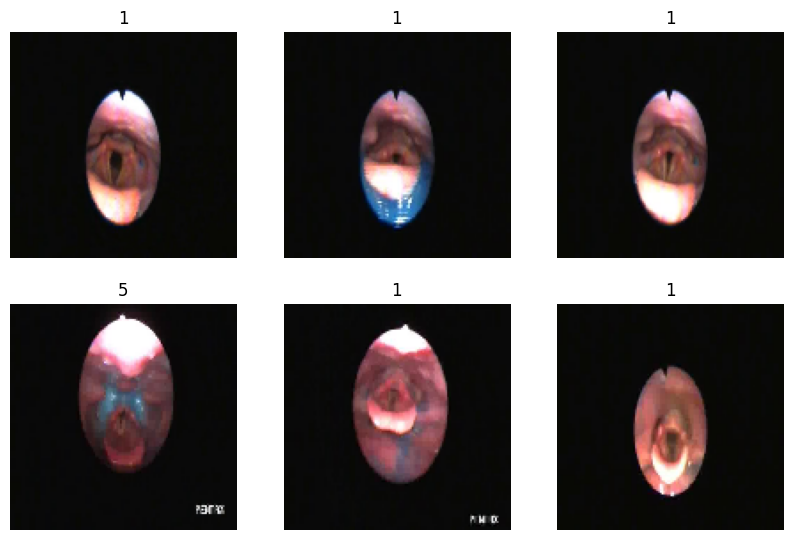

In [ ]:
# mostrando lotes de imagens

for image,labels in ds_train.take(1): #definindo um lote
    plt.figure(figsize=(10,10))
    for i in range(6): #mostrando 6 imagens
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy())
        plt.title(class_names[labels[i].numpy().tolist().index(1)])
        plt.axis("off")

In [ ]:
# carregamento dos dados de treinamento e validação

AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # imagens ficam na memoria depoisde serem carregadas fora do disco
ds_valid = ds_valid.cache().prefetch(buffer_size=AUTOTUNE) # sobrepoe os dados de pré-processamento durante o treinamento

In [ ]:
# definição de camadas random

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# camada de data augmentation

data_augmentation = keras.Sequential([
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomFlip(mode="horizontal"),
    preprocessing.RandomRotation(factor=0.1),

])

In [ ]:
# criação do modelo de treinamento

model = keras.Sequential([


    layers.InputLayer(input_shape=[128, 128, 3]),

    #pré-processamento
    data_augmentation,

    layers.Rescaling(1./255),


    #Base,
    layers.BatchNormalization(), #camada de normalização dos dados
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),

    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),


    # Head
    layers.BatchNormalization(),
    layers.GlobalMaxPooling2D(),
    layers.Dense(len(class_names),activation="softmax") #camada de output
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 batch_normalization (Batch  (None, 128, 128, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)       

In [ ]:
# redução de learning rate

# função para verificar quando devemos reduzir o learning rate, caso a val_loss não tenha mudanças por 2 epochs

#o lr é reduzido por um factor de 0.1
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001)

In [ ]:
# otimizador utilizado - Adam, algoritmo om adaptative learning rate
optimizer = tf.keras.optimizers.Adam(epsilon=0.01,learning_rate=0.01)

In [ ]:
# fase de treinamento
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    callbacks=[reduce_lr],
)

Epoch 1/30
5/5 [==============================] - 54s 12s/step - loss: 4.8549 - accuracy: 0.6073 - val_loss: 0.6716 - val_accuracy: 0.5659 - lr: 0.0100
Epoch 2/30
5/5 [==============================] - 29s 6s/step - loss: 0.4119 - accuracy: 0.8218 - val_loss: 0.6496 - val_accuracy: 0.5659 - lr: 0.0100
Epoch 3/30
5/5 [==============================] - 30s 7s/step - loss: 0.3373 - accuracy: 0.8416 - val_loss: 0.6555 - val_accuracy: 0.6822 - lr: 0.0100
Epoch 4/30
5/5 [==============================] - 29s 6s/step - loss: 0.2939 - accuracy: 0.8746 - val_loss: 0.6576 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 5/30
5/5 [==============================] - 30s 7s/step - loss: 0.2235 - accuracy: 0.9142 - val_loss: 0.6524 - val_accuracy: 0.7054 - lr: 1.0000e-03
Epoch 6/30
5/5 [==============================] - 29s 6s/step - loss: 0.2263 - accuracy: 0.9109 - val_loss: 0.6565 - val_accuracy: 0.7364 - lr: 1.0000e-03
Epoch 7/30
5/5 [==============================] - 28s 6s/step - loss: 0.2207 - accura

In [ ]:
# teste da classificação

test_images1 = [image.numpy() for image,labels in ds_valid.take(-1)][0]
test_labels1 = [labels.numpy() for image,labels in ds_valid.take(-1)][0]

test_labels1 = np.argmax(test_labels1,axis=-1)
predict_labels1 = np.argmax(model.predict(test_images1),axis=-1)

print(classification_report(test_labels1,predict_labels1,target_names=class_names))

2/2 [==============================] - 1s 559ms/step
              precision    recall  f1-score   support

           1       0.61      1.00      0.76        36
           5       1.00      0.18      0.30        28

    accuracy                           0.64        64
   macro avg       0.81      0.59      0.53        64
weighted avg       0.78      0.64      0.56        64



2/2 [==============================] - 1s 563ms/step


<Axes: title={'center': 'Matriz de confusão para os dados testados'}>

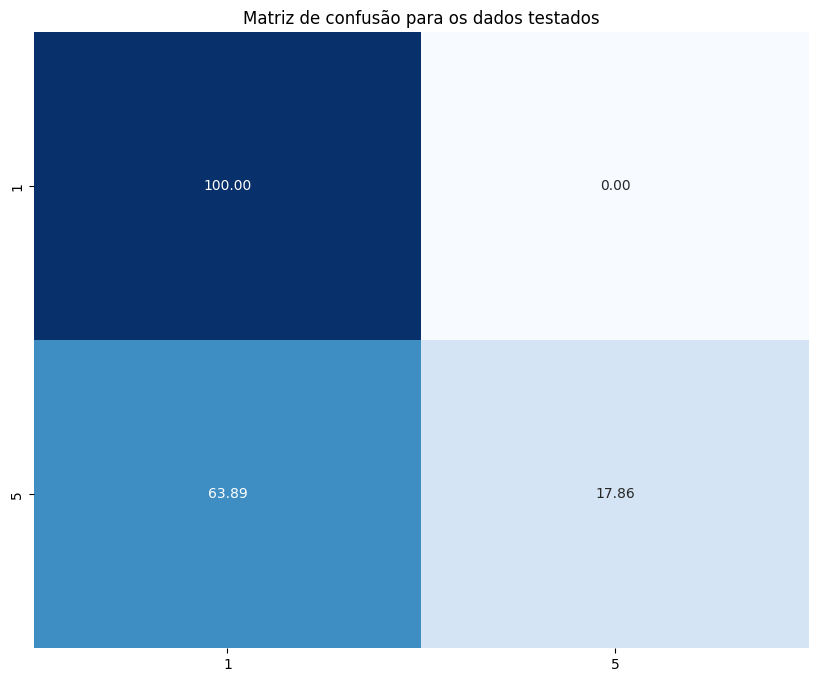

In [ ]:
# matriz de confusão

cn1 = confusion_matrix(test_labels1,np.argmax(model.predict(test_images1),axis=-1))
plt.figure(figsize=(10,8))
plt.title("Matriz de confusão para os dados testados")
sns.heatmap((cn1/np.sum(cn1,axis=-1)*100), annot=True, cmap='Blues',fmt=".2f",cbar=False,yticklabels=class_names,
           xticklabels=class_names)

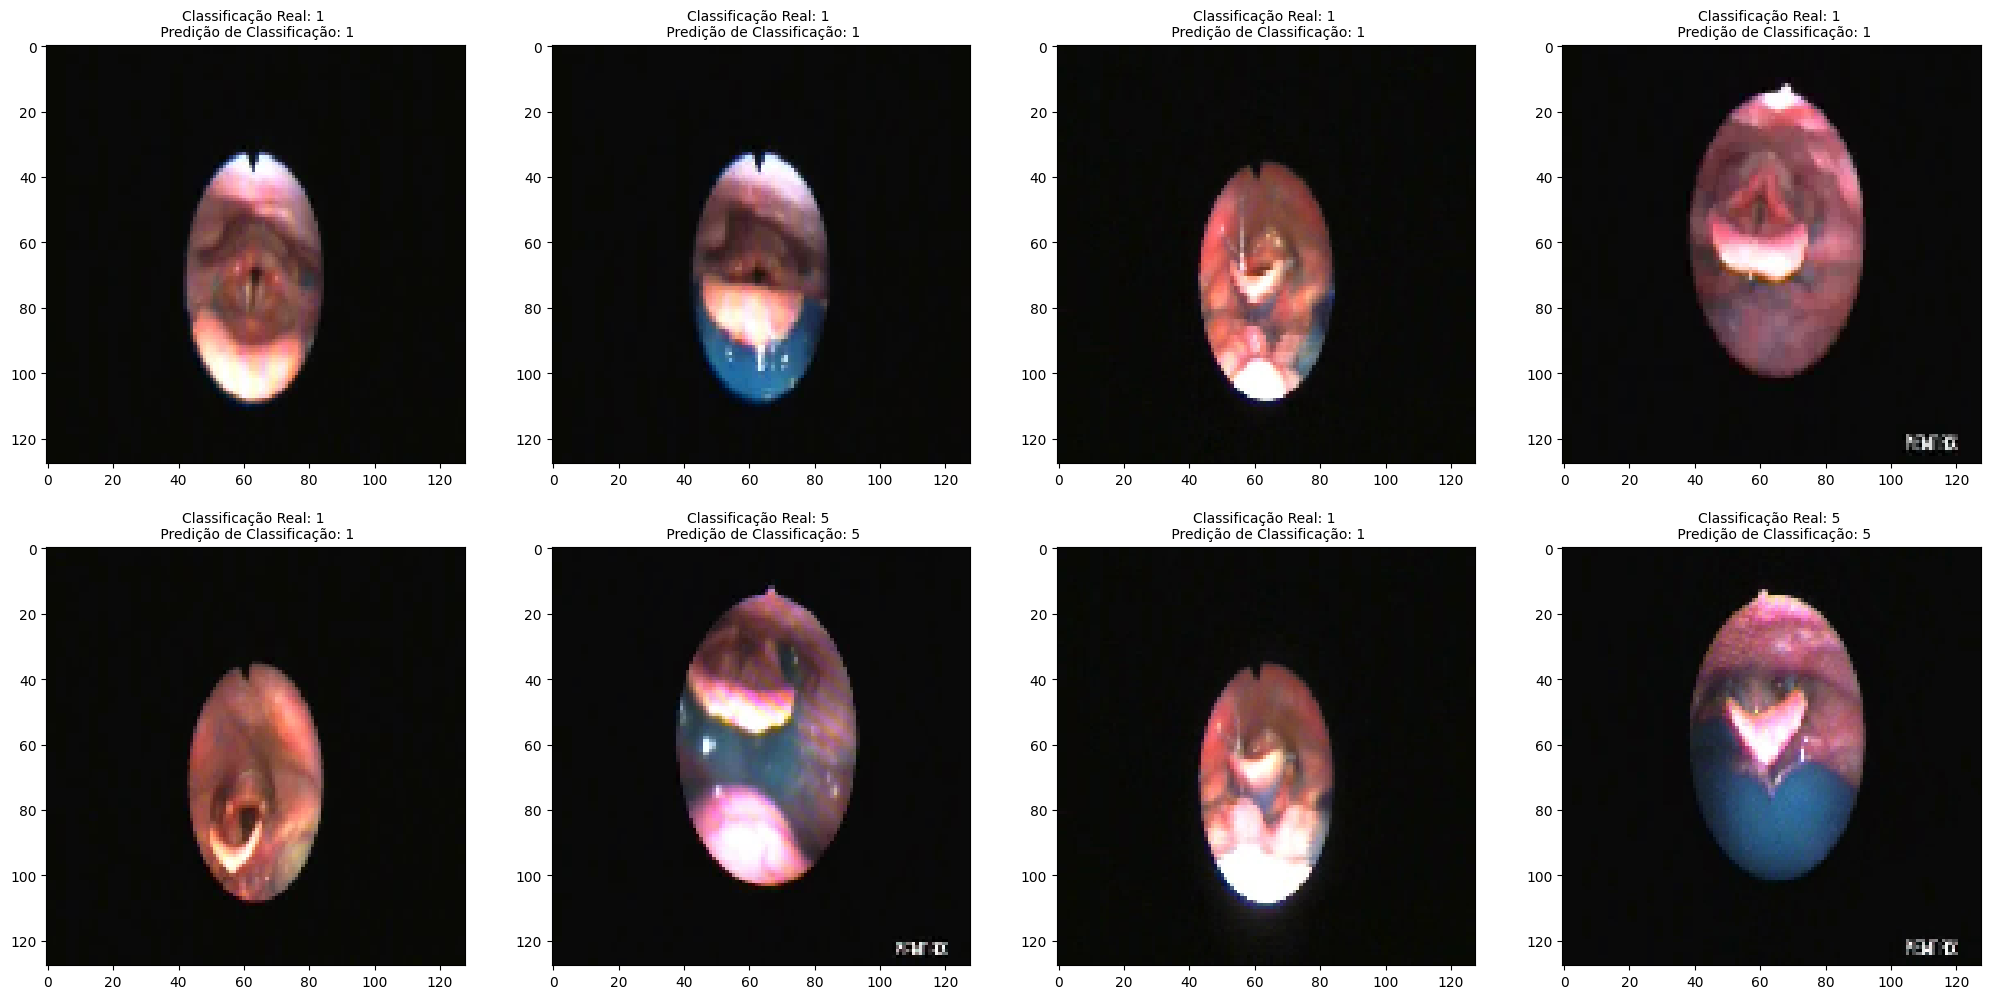

In [ ]:
# visualização das predições

plt.figure(figsize=(25,25))
for i in range(8): #mostrar 8 predições
    ax = plt.subplot(4,4,i+1)
    plt.imshow(test_images1[i])
    plt.title(f"Classificação Real: {class_names[test_labels1[i]]} \n Predição de Classificação: {class_names[test_labels1[i]]}",
             fontsize=10)

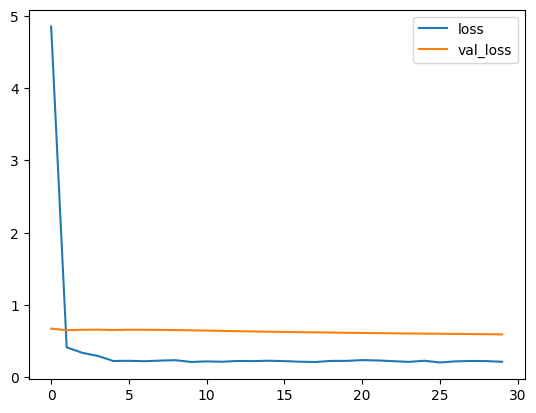

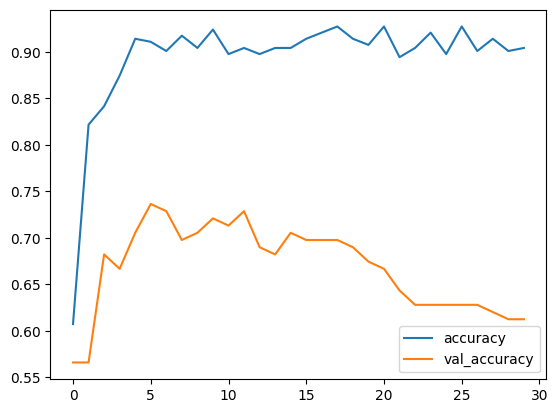

In [ ]:
# curva de aprendizagem

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();